# Workflow Outline
This notebook is used to conduct first round of experiment. 

First we train with Children's story dataset (categorical) to obtain baseline.

Then we train with Children's story combined with Emobank to get some results

## Install & Import modules

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 14.1 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn as nn
import transformers
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
import copy
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


## Import data

In [3]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

## Set up data pipeline

In [4]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
EBAT_filename = "EmoBank_AffectiveText.csv"
CHILDREN_filename = "children_highAgree.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))
df = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EBAT_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
df_children.head()

Children story dataset: 1207
Emobank dataset: 9814


,Unnamed: 0,sentence,label
0,0,"He looked around on every side and exclaimed, ...",4
1,1,"Then he got up and clambered out of the cave, ...",3
2,2,"""Alas, thou canst not help me.""",3
3,3,"They leapt nimbly upstairs and downstairs, and...",2
4,4,"Then she opened the door of the small house, a...",2


In [5]:
# some global variables 
# EKMAN_EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
# EKMAN_MAP = {'H': 'joy', 'N': 'neutral', 'F': 'fear', 'A': 'anger', 'S': 'surprise', 'Sa': 'sadness', 'D': 'disgust'}
EKMAN_EMOTIONS = ['anger-disgust', 'fear', 'happy', 'sad', 'surprise']
NUM_CLASSES_EKMAN = 5
VAD_EMOTIONS = ['V', 'A', 'D']

EMOTION_NAMES = ['Ekman', 'VAD']
EMOTION_DIMS = [1, 3] # output dims

# Load data into numpy
x_ekman_raw = list(df_children['sentence'])
y_ekman_raw = df_children['label'].to_numpy()

x_vad_raw = list(df_emobank['text'])
y_vad_raw = df_emobank[VAD_EMOTIONS].to_numpy()

# Example:
print(x_ekman_raw[0])
print(y_ekman_raw[0])

print(x_vad_raw[0])
print(y_vad_raw[0])


He looked around on every side and exclaimed, "Oh, heavens, where am I?"
4
Remember what she said in my last letter? "
[3.  3.  3.2]


In [6]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

encoded_input = tokenizer(x_ekman_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_ekman_input = encoded_input['input_ids']
X_ekman_mask = encoded_input['attention_mask']

encoded_input = tokenizer(x_vad_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_vad_input = encoded_input['input_ids']
X_vad_mask = encoded_input['attention_mask']

y_ekman_tensor = torch.tensor(y_ekman_raw, dtype=torch.float).unsqueeze(-1)
vad_placeholder = torch.zeros((len(y_ekman_tensor), EMOTION_DIMS[1]), )
y_ekman_tensor = torch.concatenate((y_ekman_tensor, vad_placeholder), dim=-1)

y_vad_tensor = torch.tensor(y_vad_raw, dtype=torch.float)
ekman_placeholder = torch.zeros((len(y_vad_tensor), EMOTION_DIMS[0]), )
y_vad_tensor = torch.concatenate((ekman_placeholder, y_vad_tensor), dim=-1)

# optional: delete df and x_text if the dataset is large

In [7]:
print(X_ekman_input.shape)
print(X_vad_input.shape)

torch.Size([1207, 155])
torch.Size([9814, 155])


In [8]:
# Normalizing y (subject to change)
y_vad_tensor = F.normalize(y_vad_tensor, dim=-1)

### Train-val-test split

* split ekman dataset into 80-10-10
* split vad dataset into 80-10-10


In [9]:
def train_val_split(X_ids, X_mask, y, ratio):
  n = X_ids.shape[0]

  perm = torch.randperm(n)

  train_size = int(ratio * n)

  X_ids_train, X_mask_train, y_train = X_ids[perm[:train_size]], X_mask[perm[:train_size]], y[perm[:train_size]]
  X_ids_val, X_mask_val, y_val = X_ids[perm[train_size:]], X_mask[perm[train_size:]], y[perm[train_size:]]

  return X_ids_train, X_mask_train, y_train, X_ids_val, X_mask_val, y_val

In [10]:
# split into train-test
X_ekman_ids_trainval, X_ekman_mask_trainval, y_ekman_trainval, X_ekman_ids_test, X_ekman_mask_test, y_ekman_test = train_val_split(X_ekman_input, X_ekman_mask, y_ekman_tensor, ratio=0.9)
X_ekman_ids_train, X_ekman_mask_train, y_ekman_train, X_ekman_ids_val, X_ekman_mask_val, y_ekman_val = train_val_split(X_ekman_ids_trainval, X_ekman_mask_trainval, y_ekman_trainval, ratio=8/9)

X_vad_ids_trainval, X_vad_mask_trainval, y_vad_trainval, X_vad_ids_test, X_vad_mask_test, y_vad_test = train_val_split(X_vad_input, X_vad_mask, y_vad_tensor, ratio=0.9)
X_vad_ids_train, X_vad_mask_train, y_vad_train, X_vad_ids_val, X_vad_mask_val, y_vad_val = train_val_split(X_vad_ids_trainval, X_vad_mask_trainval, y_vad_trainval, ratio=8/9)


In [11]:
print(f'number of ekman training points: {len(X_ekman_ids_train)}')
print(f'number of ekman validation points: {len(X_ekman_ids_val)}')
print(f'number of ekman testing points: {len(X_ekman_ids_test)}')
print(f'number of vad training points: {len(X_vad_ids_train)}')
print(f'number of vad validation points: {len(X_vad_ids_val)}')
print(f'number of vad testing points: {len(X_vad_ids_test)}')

number of ekman training points: 965
number of ekman validation points: 121
number of ekman testing points: 121
number of vad training points: 7850
number of vad validation points: 982
number of vad testing points: 982


In [12]:
# attach task labels to the two tasks 
task_ekman_train = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_train), 1))
task_ekman_val = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_val), 1))
task_ekman_test = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_test), 1))

task_vad_train = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_train), 1))
task_vad_val = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_val), 1))
task_vad_test = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_test), 1))

# Example
id = 600
# print(X_ids_train[id])
# print(X_mask_train[id])
print(y_ekman_train[id])
print(task_ekman_train[id])

tensor([2., 0., 0., 0.])
tensor([1, 0])


In [13]:
# Move everything to device
X_ekman_ids_train = X_ekman_ids_train.to(DEVICE)
X_ekman_mask_train = X_ekman_mask_train.to(DEVICE)
y_ekman_train = y_ekman_train.to(DEVICE)
task_ekman_train = task_ekman_train.to(DEVICE)

X_ekman_ids_val = X_ekman_ids_val.to(DEVICE)
X_ekman_mask_val = X_ekman_mask_val.to(DEVICE)
y_ekman_val = y_ekman_val.to(DEVICE)
task_ekman_val = task_ekman_val.to(DEVICE)

X_ekman_ids_test = X_ekman_ids_test.to(DEVICE)
X_ekman_mask_test = X_ekman_mask_test.to(DEVICE)
y_ekman_test = y_ekman_test.to(DEVICE)
task_ekman_test = task_ekman_test.to(DEVICE)

X_vad_ids_train = X_vad_ids_train.to(DEVICE)
X_vad_mask_train = X_vad_mask_train.to(DEVICE)
y_vad_train = y_vad_train.to(DEVICE)
task_vad_train = task_vad_train.to(DEVICE)

X_vad_ids_val = X_vad_ids_val.to(DEVICE)
X_vad_mask_val = X_vad_mask_val.to(DEVICE)
y_vad_val = y_vad_val.to(DEVICE)
task_vad_val = task_vad_val.to(DEVICE)

X_vad_ids_test = X_vad_ids_test.to(DEVICE)
X_vad_mask_test = X_vad_mask_test.to(DEVICE)
y_vad_test = y_vad_test.to(DEVICE)
task_vad_test = task_vad_test.to(DEVICE)

X_combined_ids_train = torch.concatenate((X_ekman_ids_train, X_vad_ids_train), dim=0)
X_combined_mask_train = torch.concatenate((X_ekman_mask_train, X_vad_mask_train), dim=0)
y_combined_train = torch.concatenate((y_ekman_train, y_vad_train), dim=0)
task_combined_train = torch.concatenate((task_ekman_train, task_vad_train), dim=0)

X_combined_ids_val = torch.concatenate((X_ekman_ids_val, X_vad_ids_val), dim=0)
X_combined_mask_val = torch.concatenate((X_ekman_mask_val, X_vad_mask_val), dim=0)
y_combined_val = torch.concatenate((y_ekman_val, y_vad_val), dim=0)
task_combined_val = torch.concatenate((task_ekman_val, task_vad_val), dim=0)

X_combined_ids_test = torch.concatenate((X_ekman_ids_test, X_vad_ids_test), dim=0)
X_combined_mask_test = torch.concatenate((X_ekman_mask_test, X_vad_mask_test), dim=0)
y_combined_test = torch.concatenate((y_ekman_test, y_vad_test), dim=0)
task_combined_test = torch.concatenate((task_ekman_test, task_vad_test), dim=0)

### Dataset

In [14]:
class EBAT_dataset(Dataset):
  def __init__(self, X_ids, X_mask, y, task, transform=None):
    self.X_ids = X_ids 
    self.X_mask = X_mask
    self.y = y # [0.4, 0.4, 0.2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.1, 0.4, 0.1, 0.2, 0.1, 0.1]
    self.task = task # [[1, 0], [0, 1]]
    self.transform = transform

  def __len__(self):
    return self.X_ids.shape[0]

  def __getitem__(self, idx):
    sample = (self.X_ids[idx], self.X_mask[idx], self.y[idx], self.task[idx])
    if self.transform:
        sample = self.transform(sample)
    return sample


In [15]:
ekman_train_dataset = EBAT_dataset(X_ekman_ids_train, X_ekman_mask_train, y_ekman_train, task_ekman_train)
ekman_val_dataset = EBAT_dataset(X_ekman_ids_val, X_ekman_mask_val, y_ekman_val, task_ekman_val)
ekman_test_dataset = EBAT_dataset(X_ekman_ids_test, X_ekman_mask_test, y_ekman_test, task_ekman_test)

vad_train_dataset = EBAT_dataset(X_vad_ids_train, X_vad_mask_train, y_vad_train, task_vad_train)
vad_val_dataset = EBAT_dataset(X_vad_ids_val, X_vad_mask_val, y_vad_val, task_vad_val)
vad_test_dataset = EBAT_dataset(X_vad_ids_test, X_vad_mask_test, y_vad_test, task_vad_test)

combined_train_dataset = EBAT_dataset(X_combined_ids_train, X_combined_mask_train, y_combined_train, task_combined_train)
combined_val_dataset = EBAT_dataset(X_combined_ids_val, X_combined_mask_val, y_combined_val, task_combined_val)
combined_test_dataset = EBAT_dataset(X_combined_ids_test, X_combined_mask_test, y_combined_test, task_combined_test)

dataset = {
    'ekman': {
        'train': ekman_train_dataset,
        'val': ekman_val_dataset,
        'test': ekman_test_dataset,
    },
    'vad': {
        'train': vad_train_dataset,
        'val': vad_val_dataset,
        'test': vad_test_dataset,
    },
    'combined': {
        'train': combined_train_dataset,
        'val': combined_val_dataset,
        'test': combined_test_dataset,
    }
}

### DataLoader

In [16]:
ekman_train_dataloader = DataLoader(dataset['ekman']['train'], batch_size = 30, shuffle=True)
ekman_val_dataloader = DataLoader(dataset['ekman']['val'], batch_size = 30, shuffle=True)
ekman_test_dataloader = DataLoader(dataset['ekman']['test'], batch_size = 30, shuffle=True)

vad_train_dataloader = DataLoader(dataset['vad']['train'], batch_size = 50, shuffle=True)
vad_val_dataloader = DataLoader(dataset['vad']['val'], batch_size = 50, shuffle=True)
vad_test_dataloader = DataLoader(dataset['vad']['test'], batch_size = 50, shuffle=True)

combined_train_dataloader = DataLoader(dataset['combined']['train'], batch_size = 50, shuffle=True)
combined_val_dataloader = DataLoader(dataset['combined']['val'], batch_size = 50, shuffle=True)
combined_test_dataloader = DataLoader(dataset['combined']['test'], batch_size = 50, shuffle=True)

dataloader = {
    'ekman': {
        'train': ekman_train_dataloader,
        'val': ekman_val_dataloader,
        'test': ekman_test_dataloader,
    },
    'vad': {
        'train': vad_train_dataloader,
        'val': vad_val_dataloader,
        'test': vad_test_dataloader,
    },
    'combined': {
        'train': combined_train_dataloader,
        'val': combined_val_dataloader,
        'test': combined_test_dataloader,
    }
}

print(f"number of batches in ekman training set: {len(dataloader['ekman']['train'])}")
print(f"number of batches in ekman val set: {len(dataloader['ekman']['val'])}")
print(f"number of batches in ekman val set: {len(dataloader['ekman']['test'])}")

# example batch
sample = next(iter(dataloader['combined']['train']))
X_id, X_mask, y, task = sample

# example single data
print(X_id[0])
print(X_mask[0])
print(y[0])
print(task[0])

number of batches in ekman training set: 97
number of batches in ekman val set: 13
number of batches in ekman val set: 13
tensor([  101,  2065,  2026,  2293,  2005,  2014,  2001,  1996,  2069,  2590,
         2518,  1010,  1045,  2052,  2681,  1037,  7570,  4135,  1997,  2014,
         2007,  1037,  3602,  1024,  1000,  6203,  2925,  1010,  2023,  2003,
        25448,  2522, 19731,  2480,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

## Model Definition

In [146]:
class MultiheadNetwork(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.shared_base = nn.Linear(768, 256)
    self.ekman_predictor = nn.Linear(256, NUM_CLASSES_EKMAN)
    self.vad_predictor = nn.Linear(256, EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    pooler_output = self.relu(self.shared_base(pooler_output))

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(pooler_output)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(pooler_output)
    y_vad = self.relu(y_vad)

    y = torch.concat((y_ekman, y_vad), dim=1)

    return y

In [94]:
class SharedEmbeddingNetwork(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.predictor = nn.Linear(768, NUM_CLASSES_EKMAN+EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    # print(hidden_state.shape)
    # print(pooler_output.shape)
    # print(task[:, 0].shape)
    # print(task[:, 0].unsqueeze(-1).shape)
    y = self.predictor(pooler_output)
    ekman_filter = task[:, 0].unsqueeze(-1)
    vad_filter = task[:, 1].unsqueeze(-1)

    y[:, 0:5] = y[:, 0:5] * ekman_filter
    y[:, 5:] = y[:, 5:] * vad_filter

    y = self.relu(y)

    return y

In [95]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [96]:
net = MultiheadNetwork(bert)
net.to(DEVICE)

print(f'moved network to {DEVICE}')

moved network to cuda:0


In [97]:
print([m.numel() for m in net.parameters() if m.requires_grad==True])

[196608, 256, 1280, 5, 768, 3]


In [98]:
with torch.no_grad():
  sample = next(iter(dataloader['combined']['train']))
  X_id, X_mask, y, task = sample

  y_pred = net(X_id, X_mask, task)

In [100]:
y_pred[:10]

tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.1588, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.1835, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.1500, 0.0163, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.1381, 0.0256, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.1391, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2192, 0.0000, 0.0000],
        [0.1815, 0.2373, 0.1917, 0.1872, 0.2024, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.1661, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2033, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2038, 0.0000, 0.0000]],
       device='cuda:0')

### Loss Function

In [131]:
class custom_MSE(object):
  def __init__(self):
    self.loss = nn.MSELoss()
    pass
  
  def __call__(self, y_gt, y_pred) -> torch.tensor:
    '''
    Computes MSE on all emotion labelling schemes

    Returns:
    -----
    losses: 1D tensor with length num_schemes
    '''
    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float)
    s = 0
    for (i, dim) in enumerate(EMOTION_DIMS):
      losses[i] = self.loss(y_gt[:, s:s+dim], y_pred[:, s:s+dim]).mean()
      s += dim
    # avg_loss = torch.norm(losses)
    return losses

class multiTaskLoss(object):
  def __init__(self):
    self.ekman_criterion = nn.CrossEntropyLoss()
    self.vad_criterion = nn.MSELoss()
  
  def __call__(self, y_pred, y_gt, task) -> torch.tensor:
    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float, device=y_pred.device)

    # ekman loss (categorical)
    ekman_loss = self.ekman_criterion(y_pred[:, 0:5], y_gt[:, 0:1].squeeze(dim=1).to(int))* task[:, 0].unsqueeze(-1)
    losses[0] = ekman_loss.mean()

    # vad loss (MSE)
    vad_loss = self.vad_criterion(y_pred[:, 5:], y_gt[:, 1:]) * task[:, 1].unsqueeze(-1)
    losses[1] = vad_loss.mean()

    return losses

## Training Manager

In [140]:
class TrainingManager():
  def __init__(self, net, dataloader, max_epochs=100):
    self.net = net
    self.dataloader = dataloader

    # self.criterion = nn.MSELoss()
    self.criterion = multiTaskLoss()

    self.optimizer = torch.optim.Adam(self.net.parameters())

    self.history = {
        'train_loss_ekman': [],
        'train_loss_vad': [],
        'train_loss_avg': [],
        'val_loss_ekman': [],
        'val_loss_vad': [],
        'val_loss_avg': [],
        'val_ekman_accuracy': []
    }

    self.max_epochs = max_epochs
    self.num_epochs = 0
  
  def train(self, epochs, train_label='ekman', val_label='ekman'):
    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_avg = 0

      for X_id, X_mask, y, task in tqdm(self.dataloader[train_label]['train']):
        self.optimizer.zero_grad()

        y_pred = self.net(X_id, X_mask, task)

        train_loss = self.criterion(y_pred, y, task)

        # count the number of samples
        ekman_count = task[:, 0].sum()
        vad_count = task[:, 1].sum()

        # rescale loss
        if ekman_count:
          train_loss[0] *= len(X_id) / ekman_count
        if vad_count:
          train_loss[1] *= len(X_id) / vad_count

        loss = train_loss.sum()

        loss.backward()

        self.optimizer.step()

        # storing minibatch results
        total_loss_ekman += train_loss[0].item()
        total_loss_vad += train_loss[1].item()
        total_loss_avg += torch.norm(train_loss).item()


      # storing epoch results
      val_loss_ekman, val_loss_vad, val_loss_avg, val_ekman_accuracy = self._evaluate(self.dataloader[val_label]['val'])

      total_loss_ekman /= len(self.dataloader[train_label]['train'])
      total_loss_vad /= len(self.dataloader[train_label]['train'])
      total_loss_avg /= len(self.dataloader[train_label]['train'])
    
      self.history['train_loss_ekman'].append(total_loss_ekman)
      self.history['train_loss_vad'].append(total_loss_vad)
      self.history['train_loss_avg'].append(total_loss_avg)
      self.history['val_loss_ekman'].append(val_loss_ekman)
      self.history['val_loss_vad'].append(val_loss_vad)
      self.history['val_loss_avg'].append(val_loss_avg)
      self.history['val_ekman_accuracy'].append(val_ekman_accuracy)

      print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {total_loss_ekman:.3f}, vad_loss = {total_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {val_loss_ekman:.3f}, vad_loss = {val_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_ekman_accuracy = {val_ekman_accuracy:.3f}')

      self.num_epochs += 1
  
  def _evaluate(self, dataloader=None):
    if dataloader == None:
      dataloader = self.dataloader['ekman']['test']
    with torch.no_grad():
      total_loss_avg = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      for X_id, X_mask, y, task in tqdm(dataloader):
        y_pred = self.net(X_id, X_mask, task)
        loss = self.criterion(y_pred, y, task)

        # count the number of samples
        ekman_count = task[:, 0].sum()
        vad_count = task[:, 1].sum()

        # rescale loss
        if ekman_count:
          loss[0] *= len(X_id) / ekman_count
        if vad_count:
          loss[1] *= len(X_id) / vad_count

        y_top_gt = y[:, 0:1].to(int).squeeze(dim=-1)
        y_top_pred = torch.argmax(y_pred[:, 0:5], dim=-1)

        ekman_top1_correct += torch.where(y_top_gt == y_top_pred, torch.ones_like(y_top_gt), torch.zeros_like(y_top_gt)).sum()

        total_loss_ekman += loss[0].item()
        total_loss_vad += loss[1].item()
        total_loss_avg += loss.sum().item()
    
    total_loss_ekman /= len(dataloader)
    total_loss_vad /= len(dataloader)
    total_loss_avg /= len(dataloader)
    ekman_accuracy = ekman_top1_correct.item() / len(dataloader.dataset)

    return total_loss_ekman, total_loss_vad, total_loss_avg, ekman_accuracy

  def evaluate(self, label='ekman'):
    loss, _, _, acc = self._evaluate(self.dataloader[label]['test'])

    print(f'TEST SET ({label})')
    print(f'Loss = {loss:.3f}')
    print(f'Accuracy = {acc * 100:.2f}')

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Avg loss')
    plt.plot(self.history['train_loss_avg'], label='train')
    plt.plot(self.history['val_loss_avg'], label='val')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Ekman Loss')
    plt.plot(self.history['train_loss_ekman'], label='train')
    plt.plot(self.history['val_loss_ekman'], label='val')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('VAD Loss')
    plt.plot(self.history['train_loss_vad'], label='train')
    plt.plot(self.history['val_loss_vad'], label='val')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('Ekman top1 Accuracy')
    plt.plot(self.history['val_ekman_accuracy'], label='val')
    plt.legend()

    plt.show()


In [137]:
criterion = multiTaskLoss()
X_id, X_mask, y, task = next(iter(dataloader['vad']['train']))
with torch.no_grad():
  y_pred = net2(X_id, X_mask, task)
  loss = criterion(y_pred, y, task)
print(loss)
# count the number of samples
ekman_count = task[:, 0].sum()
vad_count = task[:, 1].sum()
print(ekman_count)
print(vad_count)

print(y[0])
print(y_pred[0])

tensor([0.0000, 0.0014], device='cuda:0')
tensor(0, device='cuda:0')
tensor(50, device='cuda:0')
tensor([0.0000, 0.5531, 0.5710, 0.6067], device='cuda:0')
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.5911, 0.5758, 0.5895],
       device='cuda:0')


## Training

In [150]:
net = MultiheadNetwork(bert)
net.to(DEVICE)
training_manager_multi = TrainingManager(net, dataloader)

In [182]:
training_manager_multi.evaluate()

  0%|          | 0/13 [00:00<?, ?it/s]

TEST SET (ekman)
Loss = 1.327
Accuracy = 61.16


In [179]:
training_manager_multi.train(epochs=50, train_label='ekman', val_label='ekman')

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 0.644
Epoch 1: ekman_loss = 0.644, vad_loss = 0.000
Epoch 1: val_avg_loss = 1.089
Epoch 1: ekman_loss = 1.089, vad_loss = 0.000
Epoch 1: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 0.593
Epoch 2: ekman_loss = 0.593, vad_loss = 0.000
Epoch 2: val_avg_loss = 1.055
Epoch 2: ekman_loss = 1.055, vad_loss = 0.000
Epoch 2: val_ekman_accuracy = 0.579


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 0.586
Epoch 3: ekman_loss = 0.586, vad_loss = 0.000
Epoch 3: val_avg_loss = 1.064
Epoch 3: ekman_loss = 1.064, vad_loss = 0.000
Epoch 3: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 0.631
Epoch 4: ekman_loss = 0.631, vad_loss = 0.000
Epoch 4: val_avg_loss = 1.339
Epoch 4: ekman_loss = 1.339, vad_loss = 0.000
Epoch 4: val_ekman_accuracy = 0.537


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 0.647
Epoch 5: ekman_loss = 0.647, vad_loss = 0.000
Epoch 5: val_avg_loss = 1.129
Epoch 5: ekman_loss = 1.129, vad_loss = 0.000
Epoch 5: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 0.606
Epoch 6: ekman_loss = 0.606, vad_loss = 0.000
Epoch 6: val_avg_loss = 1.197
Epoch 6: ekman_loss = 1.197, vad_loss = 0.000
Epoch 6: val_ekman_accuracy = 0.579


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 0.593
Epoch 7: ekman_loss = 0.593, vad_loss = 0.000
Epoch 7: val_avg_loss = 1.094
Epoch 7: ekman_loss = 1.094, vad_loss = 0.000
Epoch 7: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 0.594
Epoch 8: ekman_loss = 0.594, vad_loss = 0.000
Epoch 8: val_avg_loss = 1.117
Epoch 8: ekman_loss = 1.117, vad_loss = 0.000
Epoch 8: val_ekman_accuracy = 0.636


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 0.622
Epoch 9: ekman_loss = 0.622, vad_loss = 0.000
Epoch 9: val_avg_loss = 1.109
Epoch 9: ekman_loss = 1.109, vad_loss = 0.000
Epoch 9: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 0.543
Epoch 10: ekman_loss = 0.543, vad_loss = 0.000
Epoch 10: val_avg_loss = 1.031
Epoch 10: ekman_loss = 1.031, vad_loss = 0.000
Epoch 10: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 0.558
Epoch 11: ekman_loss = 0.558, vad_loss = 0.000
Epoch 11: val_avg_loss = 1.143
Epoch 11: ekman_loss = 1.143, vad_loss = 0.000
Epoch 11: val_ekman_accuracy = 0.545


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 0.571
Epoch 12: ekman_loss = 0.571, vad_loss = 0.000
Epoch 12: val_avg_loss = 1.013
Epoch 12: ekman_loss = 1.013, vad_loss = 0.000
Epoch 12: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 0.563
Epoch 13: ekman_loss = 0.563, vad_loss = 0.000
Epoch 13: val_avg_loss = 0.981
Epoch 13: ekman_loss = 0.981, vad_loss = 0.000
Epoch 13: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 0.535
Epoch 14: ekman_loss = 0.535, vad_loss = 0.000
Epoch 14: val_avg_loss = 1.109
Epoch 14: ekman_loss = 1.109, vad_loss = 0.000
Epoch 14: val_ekman_accuracy = 0.628


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 0.577
Epoch 15: ekman_loss = 0.577, vad_loss = 0.000
Epoch 15: val_avg_loss = 1.137
Epoch 15: ekman_loss = 1.137, vad_loss = 0.000
Epoch 15: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 0.545
Epoch 16: ekman_loss = 0.545, vad_loss = 0.000
Epoch 16: val_avg_loss = 1.200
Epoch 16: ekman_loss = 1.200, vad_loss = 0.000
Epoch 16: val_ekman_accuracy = 0.554


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 0.606
Epoch 17: ekman_loss = 0.606, vad_loss = 0.000
Epoch 17: val_avg_loss = 1.058
Epoch 17: ekman_loss = 1.058, vad_loss = 0.000
Epoch 17: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 0.554
Epoch 18: ekman_loss = 0.554, vad_loss = 0.000
Epoch 18: val_avg_loss = 1.050
Epoch 18: ekman_loss = 1.050, vad_loss = 0.000
Epoch 18: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 0.538
Epoch 19: ekman_loss = 0.538, vad_loss = 0.000
Epoch 19: val_avg_loss = 1.500
Epoch 19: ekman_loss = 1.500, vad_loss = 0.000
Epoch 19: val_ekman_accuracy = 0.587


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 0.574
Epoch 20: ekman_loss = 0.574, vad_loss = 0.000
Epoch 20: val_avg_loss = 1.302
Epoch 20: ekman_loss = 1.302, vad_loss = 0.000
Epoch 20: val_ekman_accuracy = 0.636


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 0.502
Epoch 21: ekman_loss = 0.502, vad_loss = 0.000
Epoch 21: val_avg_loss = 1.310
Epoch 21: ekman_loss = 1.310, vad_loss = 0.000
Epoch 21: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 0.562
Epoch 22: ekman_loss = 0.562, vad_loss = 0.000
Epoch 22: val_avg_loss = 1.606
Epoch 22: ekman_loss = 1.606, vad_loss = 0.000
Epoch 22: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 0.500
Epoch 23: ekman_loss = 0.500, vad_loss = 0.000
Epoch 23: val_avg_loss = 1.295
Epoch 23: ekman_loss = 1.295, vad_loss = 0.000
Epoch 23: val_ekman_accuracy = 0.562


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.529
Epoch 24: ekman_loss = 0.529, vad_loss = 0.000
Epoch 24: val_avg_loss = 1.079
Epoch 24: ekman_loss = 1.079, vad_loss = 0.000
Epoch 24: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.485
Epoch 25: ekman_loss = 0.485, vad_loss = 0.000
Epoch 25: val_avg_loss = 0.991
Epoch 25: ekman_loss = 0.991, vad_loss = 0.000
Epoch 25: val_ekman_accuracy = 0.653


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.526
Epoch 26: ekman_loss = 0.526, vad_loss = 0.000
Epoch 26: val_avg_loss = 1.294
Epoch 26: ekman_loss = 1.294, vad_loss = 0.000
Epoch 26: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.557
Epoch 27: ekman_loss = 0.557, vad_loss = 0.000
Epoch 27: val_avg_loss = 1.178
Epoch 27: ekman_loss = 1.178, vad_loss = 0.000
Epoch 27: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.476
Epoch 28: ekman_loss = 0.476, vad_loss = 0.000
Epoch 28: val_avg_loss = 1.630
Epoch 28: ekman_loss = 1.630, vad_loss = 0.000
Epoch 28: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.529
Epoch 29: ekman_loss = 0.529, vad_loss = 0.000
Epoch 29: val_avg_loss = 1.579
Epoch 29: ekman_loss = 1.579, vad_loss = 0.000
Epoch 29: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.507
Epoch 30: ekman_loss = 0.507, vad_loss = 0.000
Epoch 30: val_avg_loss = 1.314
Epoch 30: ekman_loss = 1.314, vad_loss = 0.000
Epoch 30: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.481
Epoch 31: ekman_loss = 0.481, vad_loss = 0.000
Epoch 31: val_avg_loss = 1.267
Epoch 31: ekman_loss = 1.267, vad_loss = 0.000
Epoch 31: val_ekman_accuracy = 0.537


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.544
Epoch 32: ekman_loss = 0.544, vad_loss = 0.000
Epoch 32: val_avg_loss = 1.162
Epoch 32: ekman_loss = 1.162, vad_loss = 0.000
Epoch 32: val_ekman_accuracy = 0.587


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.495
Epoch 33: ekman_loss = 0.495, vad_loss = 0.000
Epoch 33: val_avg_loss = 1.293
Epoch 33: ekman_loss = 1.293, vad_loss = 0.000
Epoch 33: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.499
Epoch 34: ekman_loss = 0.499, vad_loss = 0.000
Epoch 34: val_avg_loss = 1.780
Epoch 34: ekman_loss = 1.780, vad_loss = 0.000
Epoch 34: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.494
Epoch 35: ekman_loss = 0.494, vad_loss = 0.000
Epoch 35: val_avg_loss = 1.169
Epoch 35: ekman_loss = 1.169, vad_loss = 0.000
Epoch 35: val_ekman_accuracy = 0.628


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.453
Epoch 36: ekman_loss = 0.453, vad_loss = 0.000
Epoch 36: val_avg_loss = 1.181
Epoch 36: ekman_loss = 1.181, vad_loss = 0.000
Epoch 36: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.543
Epoch 37: ekman_loss = 0.543, vad_loss = 0.000
Epoch 37: val_avg_loss = 1.089
Epoch 37: ekman_loss = 1.089, vad_loss = 0.000
Epoch 37: val_ekman_accuracy = 0.661


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.506
Epoch 38: ekman_loss = 0.506, vad_loss = 0.000
Epoch 38: val_avg_loss = 1.362
Epoch 38: ekman_loss = 1.362, vad_loss = 0.000
Epoch 38: val_ekman_accuracy = 0.521


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.447
Epoch 39: ekman_loss = 0.447, vad_loss = 0.000
Epoch 39: val_avg_loss = 1.198
Epoch 39: ekman_loss = 1.198, vad_loss = 0.000
Epoch 39: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.474
Epoch 40: ekman_loss = 0.474, vad_loss = 0.000
Epoch 40: val_avg_loss = 1.289
Epoch 40: ekman_loss = 1.289, vad_loss = 0.000
Epoch 40: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.430
Epoch 41: ekman_loss = 0.430, vad_loss = 0.000
Epoch 41: val_avg_loss = 1.256
Epoch 41: ekman_loss = 1.256, vad_loss = 0.000
Epoch 41: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.486
Epoch 42: ekman_loss = 0.486, vad_loss = 0.000
Epoch 42: val_avg_loss = 1.433
Epoch 42: ekman_loss = 1.433, vad_loss = 0.000
Epoch 42: val_ekman_accuracy = 0.628


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.424
Epoch 43: ekman_loss = 0.424, vad_loss = 0.000
Epoch 43: val_avg_loss = 1.129
Epoch 43: ekman_loss = 1.129, vad_loss = 0.000
Epoch 43: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.453
Epoch 44: ekman_loss = 0.453, vad_loss = 0.000
Epoch 44: val_avg_loss = 1.229
Epoch 44: ekman_loss = 1.229, vad_loss = 0.000
Epoch 44: val_ekman_accuracy = 0.587


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.436
Epoch 45: ekman_loss = 0.436, vad_loss = 0.000
Epoch 45: val_avg_loss = 1.205
Epoch 45: ekman_loss = 1.205, vad_loss = 0.000
Epoch 45: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.563
Epoch 46: ekman_loss = 0.563, vad_loss = 0.000
Epoch 46: val_avg_loss = 1.271
Epoch 46: ekman_loss = 1.271, vad_loss = 0.000
Epoch 46: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.416
Epoch 47: ekman_loss = 0.416, vad_loss = 0.000
Epoch 47: val_avg_loss = 1.210
Epoch 47: ekman_loss = 1.210, vad_loss = 0.000
Epoch 47: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.441
Epoch 48: ekman_loss = 0.441, vad_loss = 0.000
Epoch 48: val_avg_loss = 1.240
Epoch 48: ekman_loss = 1.240, vad_loss = 0.000
Epoch 48: val_ekman_accuracy = 0.554


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.416
Epoch 49: ekman_loss = 0.416, vad_loss = 0.000
Epoch 49: val_avg_loss = 1.147
Epoch 49: ekman_loss = 1.147, vad_loss = 0.000
Epoch 49: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.467
Epoch 50: ekman_loss = 0.467, vad_loss = 0.000
Epoch 50: val_avg_loss = 1.505
Epoch 50: ekman_loss = 1.505, vad_loss = 0.000
Epoch 50: val_ekman_accuracy = 0.620


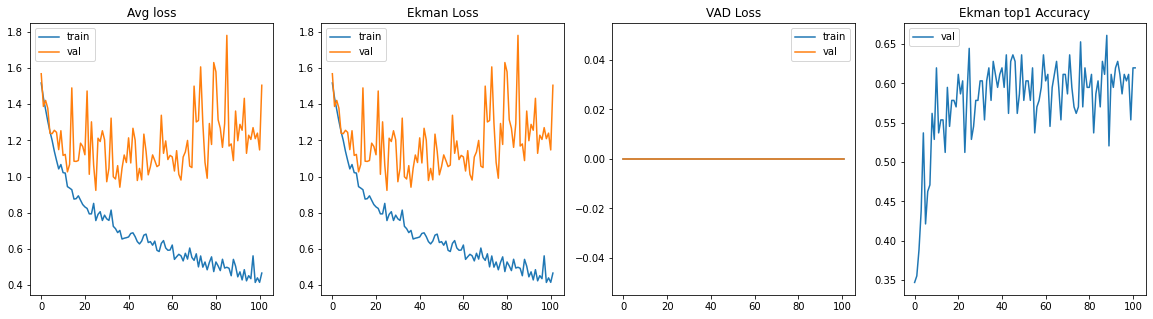

In [180]:
training_manager_multi.plot_history()

In [156]:
net2 = MultiheadNetwork(bert)
net2.to(DEVICE)
training_manager_multi_combined = TrainingManager(net2, dataloader)

In [188]:
training_manager_multi_combined.evaluate(label='ekman')

  0%|          | 0/13 [00:00<?, ?it/s]

TEST SET (ekman)
Loss = 1.040
Accuracy = 69.42


In [185]:
training_manager_multi_combined.train(epochs=10, train_label='combined', val_label='ekman')

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.486
Epoch 1: ekman_loss = 1.486, vad_loss = 0.001
Epoch 1: val_avg_loss = 1.143
Epoch 1: ekman_loss = 1.143, vad_loss = 0.000
Epoch 1: val_ekman_accuracy = 0.579


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.488
Epoch 2: ekman_loss = 1.488, vad_loss = 0.001
Epoch 2: val_avg_loss = 1.117
Epoch 2: ekman_loss = 1.117, vad_loss = 0.000
Epoch 2: val_ekman_accuracy = 0.595


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.496
Epoch 3: ekman_loss = 1.496, vad_loss = 0.001
Epoch 3: val_avg_loss = 1.053
Epoch 3: ekman_loss = 1.053, vad_loss = 0.000
Epoch 3: val_ekman_accuracy = 0.579


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.489
Epoch 4: ekman_loss = 1.489, vad_loss = 0.001
Epoch 4: val_avg_loss = 1.063
Epoch 4: ekman_loss = 1.063, vad_loss = 0.000
Epoch 4: val_ekman_accuracy = 0.645


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.484
Epoch 5: ekman_loss = 1.484, vad_loss = 0.001
Epoch 5: val_avg_loss = 1.261
Epoch 5: ekman_loss = 1.261, vad_loss = 0.000
Epoch 5: val_ekman_accuracy = 0.620


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.495
Epoch 6: ekman_loss = 1.495, vad_loss = 0.001
Epoch 6: val_avg_loss = 1.067
Epoch 6: ekman_loss = 1.067, vad_loss = 0.000
Epoch 6: val_ekman_accuracy = 0.612


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.488
Epoch 7: ekman_loss = 1.488, vad_loss = 0.001
Epoch 7: val_avg_loss = 1.217
Epoch 7: ekman_loss = 1.217, vad_loss = 0.000
Epoch 7: val_ekman_accuracy = 0.579


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.494
Epoch 8: ekman_loss = 1.494, vad_loss = 0.001
Epoch 8: val_avg_loss = 1.077
Epoch 8: ekman_loss = 1.077, vad_loss = 0.000
Epoch 8: val_ekman_accuracy = 0.570


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.486
Epoch 9: ekman_loss = 1.486, vad_loss = 0.001
Epoch 9: val_avg_loss = 1.007
Epoch 9: ekman_loss = 1.007, vad_loss = 0.000
Epoch 9: val_ekman_accuracy = 0.628


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.494
Epoch 10: ekman_loss = 1.494, vad_loss = 0.001
Epoch 10: val_avg_loss = 1.079
Epoch 10: ekman_loss = 1.079, vad_loss = 0.000
Epoch 10: val_ekman_accuracy = 0.612


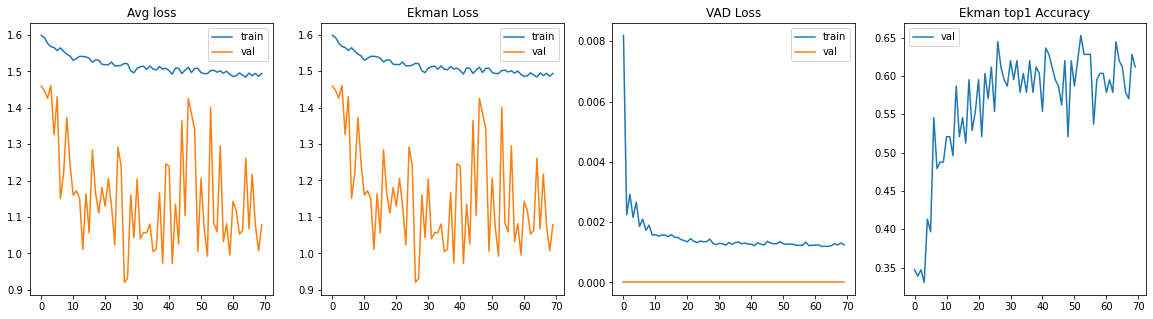

In [187]:
training_manager_multi_combined.plot_history()

## Qualitative Evaluation

In [176]:
results_df = pd.DataFrame([], columns = EKMAN_EMOTIONS + VAD_EMOTIONS)
NUM_EXAMPLES = 10
with torch.no_grad():
  sample = next(iter(dataloader['combined']['test']))
  X_id, X_mask, y, task = sample
  y_ekman = torch.nn.functional.one_hot(y[:, 0].to(int), num_classes = 5)
  y_display = torch.concatenate((y_ekman, y[:, 1:]), dim=-1)
  y_pred = net2(X_id, X_mask, task)
  
  for i in range(NUM_EXAMPLES):
    sent = tokenizer.decode(X_id[i], skip_special_tokens=True)
    row_gt = {heading: val for heading, val, in zip(results_df.columns,y_display[i].cpu().numpy())}
    row_pred = {heading: val for heading, val, in zip(results_df.columns, y_pred[i].cpu().numpy())}
    results_df = pd.concat((results_df, pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}'])))
    print(sent)
results_df

a short bus ride away is cheung sha beach, 3 km ( 2 miles ) long, and popular for its white sand and excellent facilities.
johnlopresti said... thought i would post a link with a cute title related to the post.
he was wearing a new jacket and snow boots, but he had on a hawaiian shirt underneath and khaki shorts of all things.
and our roots go deep.
sri lanka clashes kill 129 troops
i'm gonna take the plug out.
in return, we will recognize target as a sponsor during our event and in the event program.
experience the peace and beauty of coastal rhythms.
" the core of our strategy is to lead in technology and attack the high - performance segments of the market, " said john kelly, senior vice president in charge of ibm's technology group.
enclosures


,anger-disgust,fear,happy,sad,surprise,V,A,D
gt 0,1.000000,0.000000,0.000000,0.000000,0.000000,0.600444,0.554256,0.576426
pred 0,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.577078,0.554826,0.569422
gt 1,1.000000,0.000000,0.000000,0.000000,0.000000,0.667655,0.505799,0.546263
pred 1,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.576921,0.571002,0.580984
gt 2,1.000000,0.000000,0.000000,0.000000,0.000000,0.562718,0.562718,0.605555
pred 2,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.550031,0.586517,0.591497
gt 3,1.000000,0.000000,0.000000,0.000000,0.000000,0.564532,0.564532,0.602168
pred 3,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.606954,0.544989,0.574708
gt 4,1.000000,0.000000,0.000000,0.000000,0.000000,0.429548,0.751708,0.500423
pred 4,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.509981,0.664883,0.625027


In [ ]:
EKMAN_EMOTIONS

['anger-disgust', 'fear', 'happy', 'sad', 'surprise']